In [1]:
import sys, os, time, shutil, random
from pathlib import Path
if '_cwd' not in locals():
    _cwd = os.getcwd()
    os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm.notebook import tqdm
import torch
from torch import nn, optim as opt
import torch.nn.functional as F
import torch.distributions as distrib
from torch.utils.data import Dataset, DataLoader, TensorDataset

%matplotlib notebook
import matplotlib.pyplot as plt

# from src.helix import helix_labels, helix_observations, ToyVAE
from src.shapes import ShapesVAE, Shapes3D

import omnifig as fig

from omnilearn import util

# fig.initialize('sae')

In [2]:
device = 'cuda'

In [3]:
model = ShapesVAE()
model.load_state_dict(torch.load('model_a.pt'))
model.to(device)

ShapesVAE(
  (encoder): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
      (nonlin): ELU(alpha=1.0)
    )
    (1): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
      (nonlin): ELU(alpha=1.0)
    )
    (2): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
      (nonlin): ELU(alpha=1.0)
    )
    (3): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2

In [4]:
# from plethora import datasets

In [4]:
# dataset = datasets.Shapes3D(download=False, mode=None).prepare()
# len(dataset)

In [5]:
# class asdg:
#     pass
# self = asdg()

In [6]:

# self.factor_order = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation']
# self.factor_sizes = {'floor_hue': 10, 'wall_hue': 10, 'object_hue': 10,
#                      'scale': 8, 'shape': 4, 'orientation': 15}
# self._factor_steps = torch.as_tensor(np.array([self.factor_sizes[f] for f in self.factor_order] + [1])[::-1].cumprod()[-2::-1].copy())

In [7]:
# self._factor_steps

In [4]:
data = Shapes3D(download=False, root=r'C:\Users\anwan\Documents\workspace\local_data\3dshapes')

In [5]:
data.images.shape

torch.Size([480000, 3, 64, 64])

In [6]:
seq = data.factor_traversal_images(5)#, base=data._factor_nums[0].long()-1)
seq.shape

torch.Size([15, 3, 64, 64])

<IPython.core.display.Javascript object>


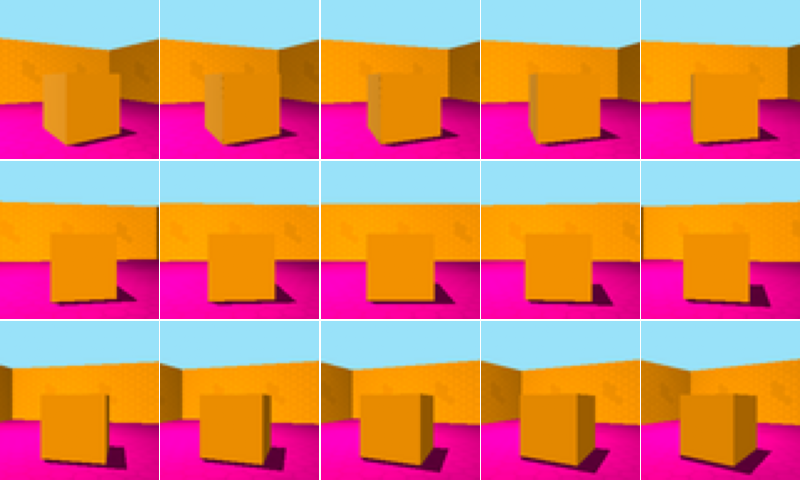

In [7]:
util.plot_imgs(seq);

In [8]:
X, _ = data[torch.randint(len(data), size=(60,))]
X.shape

torch.Size([60, 3, 64, 64])

<IPython.core.display.Javascript object>


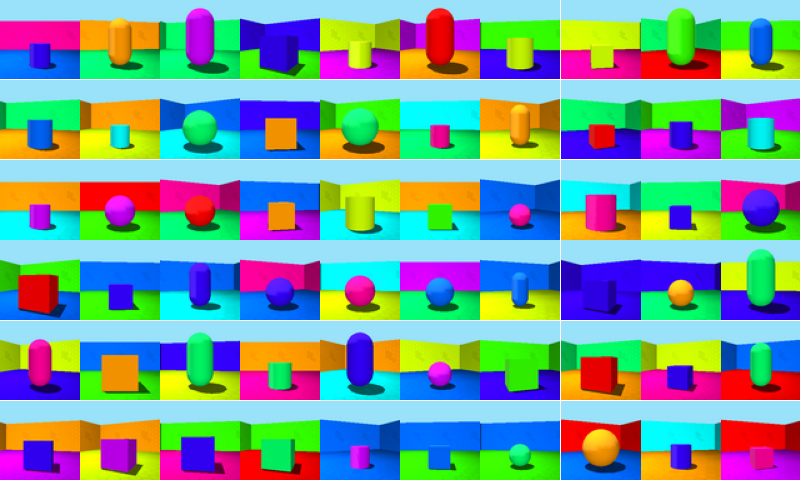

In [9]:
util.plot_imgs(X);

In [10]:
with torch.no_grad():
    R = model.reconstruct(X.cuda()).cpu()
R.shape

C:\Users\anwan\anaconda3\lib\site-packages\torch\nn\functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


torch.Size([60, 3, 64, 64])

<IPython.core.display.Javascript object>


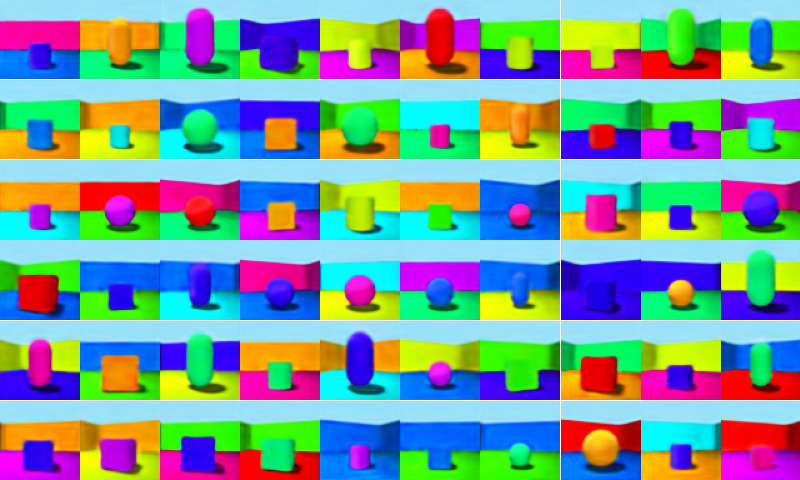

In [11]:
util.plot_imgs(R);

In [25]:
from src.responses import response_mat, conditioned_response_mat, score_from_conditioned_response_mat

In [13]:
with torch.no_grad():
    mat = response_mat(model, device=device, pbar=tqdm)

  0%|          | 0/24 [00:00<?, ?it/s]

In [14]:
mat.shape

torch.Size([24, 24])

<IPython.core.display.Javascript object>


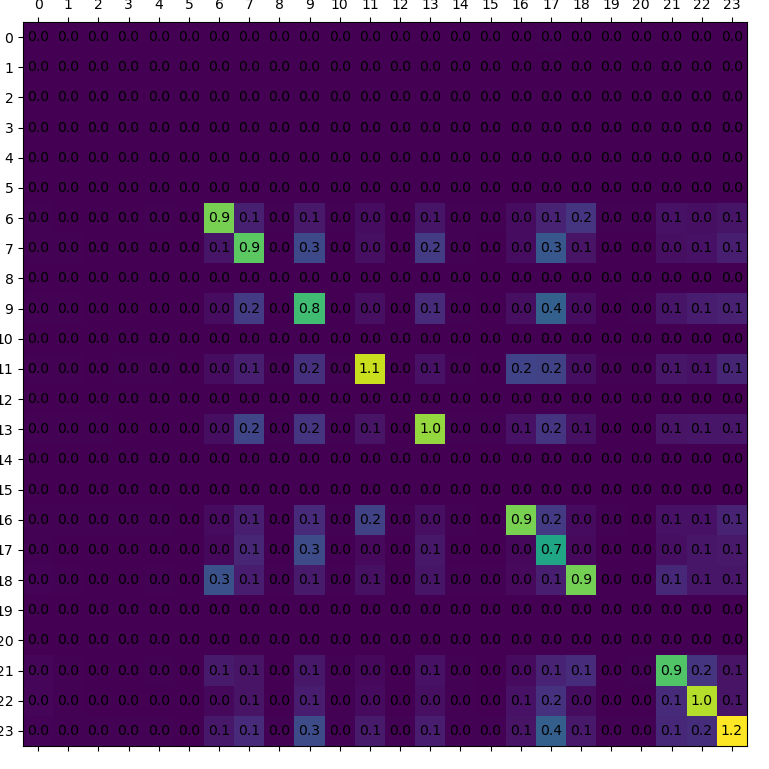

In [15]:
util.plot_mat(mat, val_fmt='.1f', figside=0.3,);

In [16]:
with torch.no_grad():
    cond_mat = conditioned_response_mat(model, data, device=device, num_traversals=20, pbar=tqdm)
cond_mat.shape

Factor floor_hue:   0%|          | 0/10 [00:00<?, ?it/s]

Factor wall_hue:   0%|          | 0/10 [00:00<?, ?it/s]

Factor object_hue:   0%|          | 0/10 [00:00<?, ?it/s]

Factor scale:   0%|          | 0/10 [00:00<?, ?it/s]

Factor shape:   0%|          | 0/10 [00:00<?, ?it/s]

Factor orientation:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([6, 10, 24])

<IPython.core.display.Javascript object>


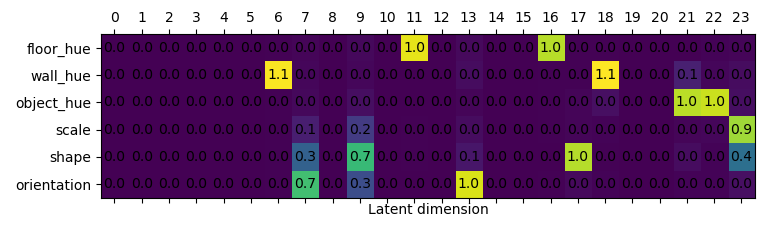

In [19]:
util.plot_mat(cond_mat.mean(1), val_fmt='.1f', figside=0.3,);
plt.yticks(range(len(data.factor_order)), data.factor_order)
plt.xlabel('Latent dimension');
plt.tight_layout();

In [27]:
score = score_from_conditioned_response_mat(cond_mat)
print(f'Causal Disentanglement Score: {score:2.4f}')

Causal Disentanglement Score: 0.8285


In [4]:
root = Path('/is/ei/fleeb/workspace/chome/saved_models/lat_resp_models')
model_name = '3ds_vae4_d-conv_d24-s2_210523-164722'

In [5]:
run = fig.quick_run('load-run', path=str(root/model_name), **{'override.device':'cpu'})

| path: '/is/ei/fleeb/workspace/chome/saved_models/lat_resp_models/3ds_vae4_d-conv_d24-s2_210523-164722'
| [Pushed] path: '/is/ei/fleeb/workspace/chome/saved_models/lat_resp_models/3ds_vae4_d-conv_d24-s2_210523-164722'
| run: [<class 'omnifig.config.ConfigDict'>]
| CREATING . (type=sae-run) (mod={'cls-run': 3, 'inline': 5, 'timed-run': 1})
|  > invisible: False (by default)
|  > use_config_root: True (by default)
|  > .path: '/is/ei/fleeb/workspace/chome/saved_models/lat_resp_models/3ds_vae4_d-conv_d24-s2_210523-164722'
|  > silent: None (by default)
|  > invisible: False (by default)
|  > use_config_root: True (by default)
|  > .path: '/is/ei/fleeb/workspace/chome/saved_models/lat_resp_models/3ds_vae4_d-conv_d24-s2_210523-164722'
|  > [Pushed] path: '/is/ei/fleeb/workspace/chome/saved_models/lat_resp_models/3ds_vae4_d-conv_d24-s2_210523-164722'
|  > [Pushed] dataset._load-ckpt: '/is/ei/fleeb/workspace/chome/saved_models/lat_resp_models/3ds_vae4_d-conv_d24-s2_210523-164722/last'
|  > [

In [6]:
model = run.get_model()

| CREATING . (type=model)
|  > _load-ckpt: '/is/ei/fleeb/workspace/chome/saved_models/lat_resp_models/3ds_vae4_d-conv_d24-s2_210523-164722/last'
|  > model._model_mod [dict with 1 item/s]
|  >  > (hybrid): 1
|  > .seed: 2
|  > CREATING model (type=vae) (mod={'hybrid': 1})
|  >  > viz-gen-hybrid: True (by default)
|  >  > viz-gen-prior: True (by default)
|  >  > skip-expensive: False (by default)
|  >  > [Pushed] reg: None
|  >  > CREATING encoder (type=multilayer) (mod={'normal': 1})
|  >  >  > autosample: None (by default)
|  >  >  > constraint-eps --> epsilon: 1e-12 (by default)
|  >  >  > soft-constraint-transform: False (by default)
|  >  >  > modify-out-layer: True (by default)
|  >  >  > _dout_key: 'latent-dim'
|  >  >  > ..latent-dim: 24
|  >  >  > _din --> ..din [list with 3 item/s]
|  >  >  >  > (0): 3
|  >  >  >  > (1): 64
|  >  >  >  > (2): 64
|  >  >  > _dout --> latent-dim: 48
|  >  >  > in_order: True (by default)
|  >  >  > first: [<class 'omnifig.config.ConfigDict'>]
| 

Loaded parameters from /is/ei/fleeb/workspace/chome/saved_models/lat_resp_models/3ds_vae4_d-conv_d24-s2_210523-164722/last


In [7]:
model

Hybrid_VAE(
  (encoder): Normal_MultiLayer(
    (layers): ModuleList(
      (0): ConvLayer(
        residual=False
        (conv): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (1): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (2): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (norm): GroupNo

In [8]:
model.state_dict()['model']['parameters'].keys()

odict_keys(['_latent', 'encoder.layers.0.conv.weight', 'encoder.layers.0.conv.bias', 'encoder.layers.0.norm.weight', 'encoder.layers.0.norm.bias', 'encoder.layers.1.conv.weight', 'encoder.layers.1.conv.bias', 'encoder.layers.1.norm.weight', 'encoder.layers.1.norm.bias', 'encoder.layers.2.conv.weight', 'encoder.layers.2.conv.bias', 'encoder.layers.2.norm.weight', 'encoder.layers.2.norm.bias', 'encoder.layers.3.conv.weight', 'encoder.layers.3.conv.bias', 'encoder.layers.3.norm.weight', 'encoder.layers.3.norm.bias', 'encoder.layers.4.conv.weight', 'encoder.layers.4.conv.bias', 'encoder.layers.4.norm.weight', 'encoder.layers.4.norm.bias', 'encoder.layers.5.1.weight', 'encoder.layers.5.1.bias', 'encoder.layers.5.3.weight', 'encoder.layers.5.3.bias', 'encoder.layers.5.5.weight', 'encoder.layers.5.5.bias', 'decoder.layers.0.0.weight', 'decoder.layers.0.0.bias', 'decoder.layers.0.2.weight', 'decoder.layers.0.2.bias', 'decoder.layers.0.4.weight', 'decoder.layers.0.4.bias', 'decoder.layers.1.con

In [10]:
params_dict = {key.replace('layers.',''): val for key,val in model.state_dict()['model']['parameters'].items() if key not in {'_latent'}}
params_dict.keys()

dict_keys(['encoder.0.conv.weight', 'encoder.0.conv.bias', 'encoder.0.norm.weight', 'encoder.0.norm.bias', 'encoder.1.conv.weight', 'encoder.1.conv.bias', 'encoder.1.norm.weight', 'encoder.1.norm.bias', 'encoder.2.conv.weight', 'encoder.2.conv.bias', 'encoder.2.norm.weight', 'encoder.2.norm.bias', 'encoder.3.conv.weight', 'encoder.3.conv.bias', 'encoder.3.norm.weight', 'encoder.3.norm.bias', 'encoder.4.conv.weight', 'encoder.4.conv.bias', 'encoder.4.norm.weight', 'encoder.4.norm.bias', 'encoder.5.1.weight', 'encoder.5.1.bias', 'encoder.5.3.weight', 'encoder.5.3.bias', 'encoder.5.5.weight', 'encoder.5.5.bias', 'decoder.0.0.weight', 'decoder.0.0.bias', 'decoder.0.2.weight', 'decoder.0.2.bias', 'decoder.0.4.weight', 'decoder.0.4.bias', 'decoder.1.conv.weight', 'decoder.1.conv.bias', 'decoder.1.norm.weight', 'decoder.1.norm.bias', 'decoder.2.conv.weight', 'decoder.2.conv.bias', 'decoder.2.norm.weight', 'decoder.2.norm.bias', 'decoder.3.conv.weight', 'decoder.3.conv.bias', 'decoder.3.norm.w

In [11]:
# torch.save(params_dict, 'model_a.pt')